In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pipeline
import random
import itertools

In [4]:
demographic_df = pd.read_sas('../data/raw_1.sas7bdat')
demo_df = pipeline.clean_demographic(demographic_df)

In [109]:
demographic_df.mean()

USERID         4.413368e+06
RG_case        5.002419e-01
YearofBirth    1.976973e+03
dtype: float64

In [5]:
gambling_series_df = pd.read_sas('../data/raw_2.sas7bdat')
gam_df = pipeline.clean_gambling(gambling_series_df)

In [6]:
rg_intervention_df = pd.read_sas('../data/raw_3.sas7bdat')
rg_info = pipeline.clean_rg_info(rg_intervention_df)

In [7]:
gam_df.head()
gam_df['weekend'] = gam_df['date'].dt.dayofweek >= 4
gb_day_in_week = gam_df.groupby('weekend')
gb_day_in_week.mean()

,user_id,product_type,turnover,hold,num_bets
weekend,,,,,
False,3.230706e+06,3.698906,347.728142,16.763593,46.320172
True,3.193773e+06,3.384506,338.787361,15.741385,43.302686


In [8]:
user_id = 5799772
pipeline.make_ts(gam_df, user_id, 10)

,user_id,product_type,turnover,hold,num_bets,weekend,hold_cum
2000-01-01,5799772,10,0.0,0.0,0,0,0.0
2000-01-02,5799772,10,0.0,0.0,0,0,0.0
2000-01-03,5799772,10,0.0,0.0,0,0,0.0
2000-01-04,5799772,10,0.0,0.0,0,0,0.0
2000-01-05,5799772,10,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...
2010-11-26,5799772,10,0.0,0.0,0,0,0.0
2010-11-27,5799772,10,0.0,0.0,0,0,0.0
2010-11-28,5799772,10,0.0,0.0,0,0,0.0
2010-11-29,5799772,10,0.0,0.0,0,0,0.0


In [9]:
def add_weighted_bets(gam_df, w_means = None):
    if not w_means:
        w_means = gam_df.groupby('product_type')['num_bets'].mean()
        w_means /= w_means[1]
    gam_df['weighted_bets'] = 0
    for product_type in gam_df['product_type'].unique():
        mask = gam_df['product_type'] == product_type
        gam_df.loc[mask,'weighted_bets'] = gam_df[mask]['num_bets'] / w_means[product_type]
    return gam_df

In [10]:
gam_test = add_weighted_bets(gam_df)

In [11]:
has_hold_data = [1,2,4,8,17]
def accum_by_date(gam_data, user_id, product_types = has_hold_data):
    '''Accumulates the turnover+hold across all product_types'''
    mask = (gam_data['user_id'] == user_id) & (gam_data['product_type'].isin(product_types))
    series = gam_data[mask].groupby('date').sum()
    series = series.drop(["product_type","user_id"], axis = 1)
    reg_date = demo_df.loc[user_id].registration_date
    #last_gamble = series['date'].max()
    idx = pd.date_range(reg_date, '2010-11-30')
    series = series.reindex(idx, fill_value=0)
    #Move this out!
    series['weekend'] = pd.DatetimeIndex(series.index).dayofweek >= 4
    series['hold_cum'] = series['hold'].cumsum()
    return series.copy()

In [12]:
all_prods = list(range(1,30))
ts_acc = accum_by_date(gam_test, 5799772, all_prods)

In [13]:
ts_acc['weekend'] = pd.DatetimeIndex(ts_acc.index).dayofweek >= 4
ts_acc
ts_acc.groupby('weekend').count()

,turnover,hold,num_bets,weighted_bets,hold_cum
weekend,,,,,
False,599,599,599,599,599
True,450,450,450,450,450


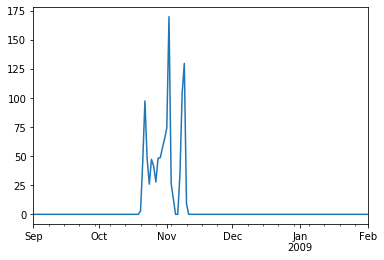

In [14]:
ts_acc['weighted_bets']['2008-09-01':'2009-02-01'].plot()

In [15]:
rg_ids = list(demo_df[demo_df['rg'] == 1].index)
no_rg_ids = list(demo_df[demo_df['rg'] == 0].index)

1


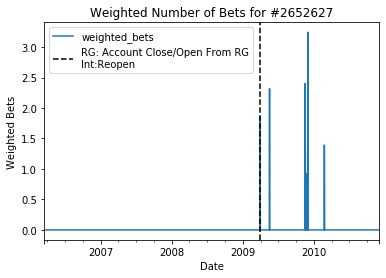

1


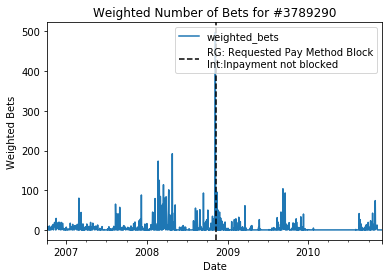

1


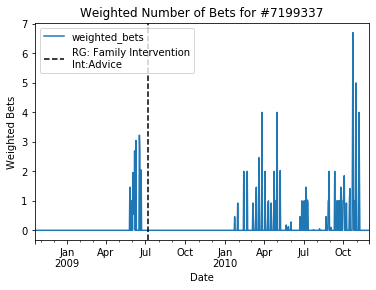

2


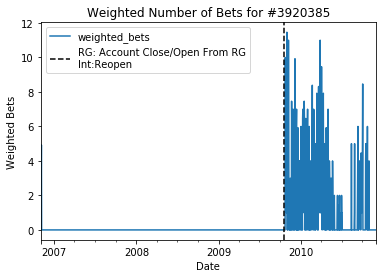

1


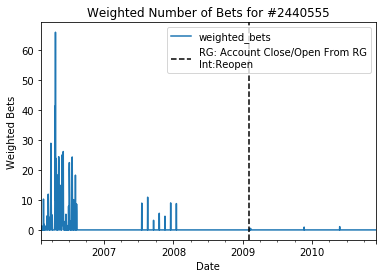

1


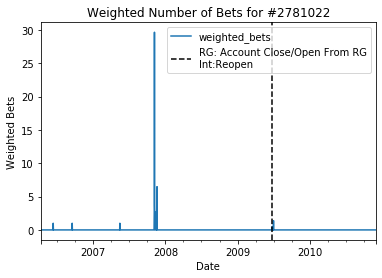

1


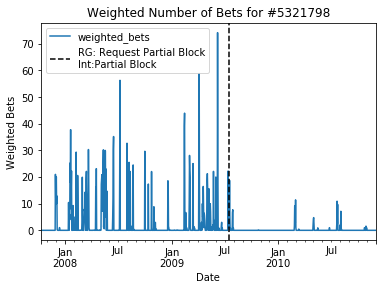

1


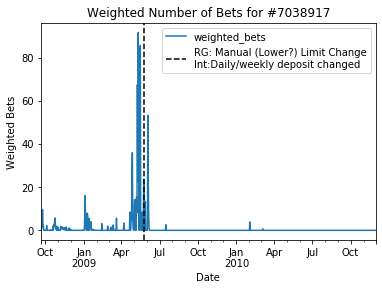

1


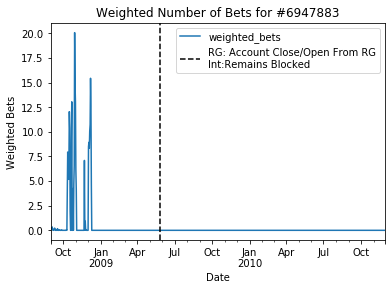

2


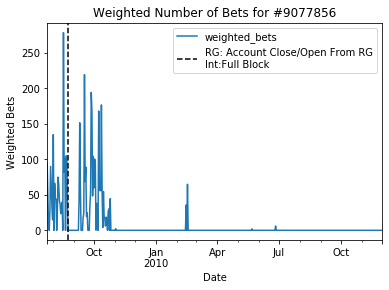

In [114]:
def plot_ts(ts, user_id, plt_column = 'hold_cum', rg_info = None):
    ts[plt_column].plot(label = plt_column)
    #ts['num_bets'].plot(label = "Cumulative Loss")
    if rg_info is not None and (user_id in rg_info.index):
        first_rg = rg_info.loc[user_id, 'first_date']
        rg_desc = rg_info.loc[user_id, 'ev_desc']
        inter_desc = rg_info.loc[user_id, 'inter_desc']
        print(rg_info.loc[user_id, 'events'])
        plt.axvline(first_rg, linestyle = "--", label = f'RG: {rg_desc}\nInt:{inter_desc}', color = 'black')
cr_mask = rg_info['event_type_first'] == 2
acc_cr_ids = list(rg_info[cr_mask].index)
#random.seed(123)
for _ in range(10):
    user_id = random.choice(rg_ids)
    all_prods = list(range(1,30))
    ts = accum_by_date(gam_test, user_id, all_prods)
    plot_ts(ts, user_id, plt_column = 'weighted_bets', rg_info = rg_info)
    plt.title(f'Weighted Number of Bets for #{user_id}')
    plt.xlabel("Date")
    plt.ylabel("Weighted Bets")
    plt.legend()
    plt.show()

In [17]:
clear_prior_block = [3324091,2336892,2874213, 4478231]
reported_prob_adv = [164641,3214045]

1


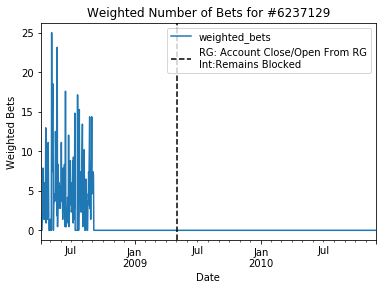

In [18]:
user_id = 6237129
all_prods = list(range(1,30))
#date_range = ['2008-02-01':'2008-02-28']
ts = accum_by_date(gam_test, user_id, all_prods)
plot_ts(ts, user_id, plt_column = 'weighted_bets', rg_info = rg_info)
plt.title(f'Weighted Number of Bets for #{user_id}')
plt.xlabel("Date")
plt.ylabel("Weighted Bets")
plt.legend()
plt.show()

Let's compare RG flagged to non RG flagged

In [36]:
rg_ids = list(demo_df[demo_df['rg'] == 1].index)
no_rg_ids = list(demo_df[demo_df['rg'] == 0].index)

In [37]:
rg_time_series = {}
all_prods = list(range(1,30))
for user_id in rg_ids:
    rg_time_series[user_id] = accum_by_date(gam_test, user_id, all_prods)

In [38]:
acc = 0
for user_id in rg_time_series:
    acc += rg_time_series[user_id].hold_cum[-1]
acc /= len(rg_time_series)
acc

5847.023986916271

In [39]:
nrg_time_series = {}
all_prods = list(range(1,30))
for user_id in no_rg_ids:
    nrg_time_series[user_id] = accum_by_date(gam_test, user_id, all_prods)

In [40]:
acc = 0
for user_id in nrg_time_series:
    acc += nrg_time_series[user_id].hold_cum[-1]
acc /= len(nrg_time_series)
acc

378.8520896504892

**Make Training Matrix**
* Target: Whether an RG event happens in the next three months
* We plan to use the following features:
    * Weekly hold data from past three months
    * Monthly hold data from past twelve
    * Summaries of history
        * Mean Activity
        * Max activity
        * Mean bets
        * Max bet
        * Weekend/Week Activity
        * Rolling windows?
    

In [98]:
user = 2062223
ts_test = rg_time_series[2062223]
ts_test

,turnover,hold,num_bets,weekend,weighted_bets,hold_cum
2005-10-26,0.0,0.0,0,False,0.000000,0.000
2005-10-27,304.0,25.0,2,False,0.051835,25.000
2005-10-28,7.0,-0.8,5,True,2.316016,24.200
2005-10-29,7.4,5.8,5,True,2.316016,30.000
2005-10-30,0.0,0.0,0,True,0.000000,30.000
...,...,...,...,...,...,...
2010-11-26,0.0,0.0,0,True,0.000000,27898.165
2010-11-27,0.0,0.0,0,True,0.000000,27898.165
2010-11-28,0.0,0.0,0,True,0.000000,27898.165
2010-11-29,0.0,0.0,0,False,0.000000,27898.165


In [99]:
ts_test.groupby('weekend').sum()

,turnover,hold,num_bets,weighted_bets,hold_cum
weekend,,,,,
False,256950.2171,12775.6771,34674,5881.653353,1.700581e+07
True,159110.2279,15122.4879,20367,5927.682039,1.275660e+07


In [104]:
week_ts = ts_test.resample('W')

AttributeError: 'DatetimeIndexResampler' object has no attribute 'drop'

In [106]:
x = week_ts.sum().drop("hold_cum", axis = 1)
x['2010-09-09':'2010-10-09']

,turnover,hold,num_bets,weekend,weighted_bets
2010-09-12,47.13,11.0,8,3.0,3.705626
2010-09-19,0.00,0.0,0,3.0,0.000000
2010-09-26,0.00,0.0,0,3.0,0.000000
2010-10-03,0.00,0.0,0,3.0,0.000000


In [51]:
month_ts = ts_test.resample('M')
month_ts.sum()

,turnover,hold,num_bets,weekend,weighted_bets,hold_cum
2005-10-31,318.40,30.00,12,3.0,4.683868,139.200
2005-11-30,9438.61,397.00,1142,12.0,146.936619,4751.410
2005-12-31,12519.50,-88.00,2337,14.0,51.895119,7669.000
2006-01-31,3220.03,686.00,614,13.0,13.701738,22563.000
2006-02-28,19790.22,702.72,1640,12.0,79.285110,37808.500
...,...,...,...,...,...,...
2010-07-31,0.00,0.00,0,14.0,0.000000,863882.115
2010-08-31,0.00,0.00,0,13.0,0.000000,863882.115
2010-09-30,47.13,11.00,8,12.0,3.705626,836273.950
2010-10-31,48.00,10.00,5,15.0,2.316016,864433.115


In [61]:
user_mask = gam_df['user_id'] == user
gam_df[user_mask].groupby('product_type').count()

,user_id,date,turnover,hold,num_bets,weekend,weighted_bets
product_type,,,,,,,
1,601,601,601,601,601,601,601
2,906,906,906,906,906,906,906
4,6,6,6,6,6,6,6
6,11,11,0,0,11,11,11
7,2,2,0,0,2,2,2
8,142,142,142,142,142,142,142
14,161,161,0,0,161,161,161
15,30,30,0,0,30,30,30
19,2,2,0,0,2,2,2


In [93]:
x = gam_df.groupby('user_id').mean()
x['rg'] = False
for user_id in x.index:
    if user_id in rg_ids:
        x.loc[user_id, 'rg'] = True

In [94]:
x

,product_type,turnover,hold,num_bets,weekend,weighted_bets,rg
user_id,,,,,,,
31965,2.042005,85.580042,10.378040,9.178862,0.444444,3.873417,True
32639,1.015152,9.488517,2.524742,1.000000,0.454545,0.991867,False
36822,8.145161,7.528308,-0.233231,3.354839,0.322581,0.715177,False
36916,1.495726,216.604561,15.121394,81.854701,0.512821,4.716987,True
38386,1.168831,4.206921,1.427086,2.285714,0.441558,2.211040,True
...,...,...,...,...,...,...,...
9821694,10.000000,NaN,NaN,15.000000,0.666667,0.843682,False
9822065,6.275000,8.274000,1.369750,33.375000,0.262500,4.363776,True
9822269,1.000000,35.241877,35.241877,1.500000,1.000000,1.500000,False


In [97]:
x.groupby('rg').mean()

,product_type,turnover,hold,num_bets,weekend,weighted_bets
rg,,,,,,
False,2.907941,88.747338,6.101446,18.453652,0.472873,2.633354
True,3.830005,390.073958,19.300520,49.598947,0.454328,5.747101


In [107]:
rg_info.head()

,events,first_date,last_date,event_type_first,inter_type_first,ev_desc,inter_desc
user_id,,,,,,,
2169867,1,2009-11-19,2009-11-19,9,18,Request Partial Block,Requested Partial Block Not Possible
7035862,1,2009-11-15,2009-11-15,9,18,Request Partial Block,Requested Partial Block Not Possible
5911218,1,2009-11-08,2009-11-08,9,18,Request Partial Block,Requested Partial Block Not Possible
5872708,1,2009-11-03,2009-11-03,9,18,Request Partial Block,Requested Partial Block Not Possible
5746942,2,2009-10-18,2009-11-03,9,18,Request Partial Block,Requested Partial Block Not Possible
